# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

79

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 台北 行天宮站 白鹿苑子 寵物友善 咖哩', 'date': '10/23', 'author': 'ally701', 'link': '/bbs/Food/M.1603462302.A.E20.html', 'text': '\n2020年10月\n\n無音樂。有圖真相網誌好讀版\n\n\n\n白鹿咖哩\n電話:(02)2507-0605\n地址:台北市中山區錦州街320號\n交通:捷運行天宮站，步行約8分鐘\n營業時間:10:00-22:00\n其他:低消100元/人。免服務費。不可訂位。寵物友善\nFB:\n\n\n從捷運行天宮站步行過來，\n大約不到10分鐘的時間。\n錦州街周邊算是滿特別的區域，\n四周辦公大樓林立，\n圍繞著捷運站的街道上，\n遍佈了許多很受歡迎的餐廳小吃，\n每次來到附近，\n總是可以挖掘到不少獨具特色的美食。\n\n「白鹿咖哩」的前身是位於民權西路站的萌萌食堂，\n許多店裡的顧客更是很忠實的追隨，\n專程來到這裡，就是獨愛這一味。\n濃厚日式風格的「白鹿咖哩」，\n一走進店內，\n就有種來到家庭餐廳的溫馨感受，\n好像來到朋友家作客般親切。\n老闆熱情的招呼聲，\n和客人們不經意的談天閒聊，\n整體氛圍非常輕鬆又自在。\n牆上裝飾的繪馬，\n四周佈置的公仔小物，\n每一種可愛的元素集結，\n讓人來到這裡，\n不但有種挖寶的興奮感，\n更讓人懷念起去日本的種種回憶。\n\n\n這裡也是寵物友善餐廳，\n大家可以帶著家裡的寶貝一同前來用餐，\n不但有提供寵物的餐點，\n更可以跟可愛的Oreo一起玩耍，\n小朋友也可以玩得超盡興，\n完全被歡樂的氣氛包圍。\n\n\n菜單中的選項不少，\n主要大致可分為咖哩、丼飯和麵食，\n多種搭配方式，\n一時之間真的讓人有選擇困難。\n\n美腿唐揚雞＄100\n炸的外層香酥，\n內部肉質依舊非常滑嫩，\n一口咬下，\n燙口的溫度結合油脂和肉汁瞬間傾洩而出，\n加上日式美乃滋作為點綴，\n更讓整體多了一絲亮點。\n不僅單吃配飯都很搭，\n當成小酌一杯時的下酒菜也超適合。\n(未成年請勿飲酒，開車也不要喝酒）\n\n日式豬排歐姆蛋起司咖哩$200(並盛)/$220(大盛)\n＋＄99 可升級為套餐\n包含\n韓式泡菜/日式溫玉/玫瑰鹽溏心蛋豆腐/\n

In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push:  
title: [廣宣] 台北信義 NARA Thai Cuisine 泰式料理 
date: 10/23 
author: chris1225 
link: /bbs/Food/M.1603466654.A.E54.html 
text: 


     店名：NARA Thai 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])




     店名：NARA Thai Cuisine 泰式料理
     地址：台北市信義區忠孝東路五段8號7F(統一時代百貨7樓)
     電話：02-2720 0958
     營業時間：週日~週四 11:00-21:30 週五.六 11:00-22:00
     試吃日期：2020.10.17

圖文並茂無音樂你上班可以偷看版（文附菜單）：


*『NARA Thai Cuisine』正宗泰國餐廳 米其林推薦泰式料理 期間限定-紫色迷幻菜餚
(2020/9/24-11/16)
*台北泰式料理 台北泰式餐廳 台北泰國菜 信義區美食 統一時代百貨美食

來自泰國的NARA Thai Cuisine 泰式料理，是許多人前去泰國必訪餐廳
不僅2019、2020連續兩年榮獲米其林推薦
也連續12年獲得Thailand Tatler 雜誌讀者評選為最佳泰國料理餐廳
這次焦糖曼和大食怪受邀試吃9月新推紫醉金迷系列餐點
準備陷入絢麗迷幻紫色風暴中

NARA Thai Cuisine 泰式料理目前台北.新北.新竹.台中皆有分店
焦糖曼選擇了離台北住處近的統一時代百貨
因為泰式料理多以合菜居多，是三五好友聚餐首選
現場餐桌多半四人起跳，其中還有大小圓桌及包廂
除此之外，也有雙人座位，也是相當適合約會、姊妹聚會的好場所

NARA Thai Cuisine 泰式料理選用泰國東北產的香米
按人頭計費，一人40元可無限續添
米粒的口感和市面常見的散硬泰國米不同
嚐起來質地柔軟，Q黏好咀嚼

鹹蛋涼拌青木瓜
冰涼的青木瓜絲，酸甜輕脆，有番茄.四季豆及鹹蛋隨側相佐
鹹蛋賦予的鹹香滋味，出乎意料外的融入，是相當開胃一道沙拉

龍鬚菜（蝦醬）
龍鬚菜本身味道平淡苦甘，不若九層塔.洋蔥...這類自身帶有鮮明氣味的蔬菜
但是NARA Thai Cuisine 泰式料理巧妙將其與蝦醬一同拌炒，味道鹹香，提升了他的層次
其中還有辣椒與蒜蓉點綴，使滋味更上一層樓

金錢蝦餅
金錢蝦餅是NARA Thai Cuisine 泰式料理的人氣餐點，推薦必點
蝦泥作為內餡，外頭以麵包粉做為麵衣將其裹附在內
金黃色澤的蝦餅，餡料甘甜，還能見到蝦末在裡頭
整體口感輕巧酥脆，咬下那一瞬間會發出＂唰＂一聲響

綠咖哩雞肉
來到泰式餐廳，咖哩系是一定要的
尤其是綠咖哩，更是南洋風味界經典中的經典
咖哩微辣的滋味

In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 1.019 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n消費時間：2020年/10月\n 地址：台中市北屯區太原路三段508號\n 電話：0...,消費 時間 年 月 地址 台中市 北屯區 太原路 三段 號 電話 營業 時間 每人 平均 價...
1,\n\n 餐廳名稱：慈惠堂米粉炒\n 消費時間：2020年/10月\n 地址：花...,餐廳 名稱 慈惠堂 米粉 炒 消費 時間 年 月 地址 花蓮縣 吉安鄉 自強路 號 營業 時...


In [11]:
raw[5]

'\n   餐廳名稱：協力香雞排\n   消費時間：2020年/10月\n   地址：桃園市中壢區福州一街247號\n   電話：03-4620289\n   營業時間：16:30-00:00, 週日一公休\n\n圖文版：\n\n\n\n    之前關於協力雞排的情報不少，只是在幾經打擊後，決定訪完\n福州一街這家協力雞排後就收手。\n\n\u3000\u3000這家協力雞排的品項挺多，也有相對少見的台南大扁。本照例\n該點雞排做比較，然而有板友提及除雞排外其它表現均優，於是從\n善如流。\n\n鹽酥雞 50元  魷魚頭 50元  台南大扁 20元  雞皮 30元\n蘿蔔糕 20元  糯米椒 30元\n\n\n\n    店家瀝油工夫很好，食材吃來乾爽。香辛料的部份僅有九層塔\n，份量不多，但乾酥不吸油。\n\n\u3000\u3000鹽酥雞軟嫩入味，略有排骨酥氣質，可惜部份帶骨比例過高。\n魷魚頭外酥內軟；雞皮薄脆如餅；台南大扁酥中有鮮。椒鹽鹹度適\n切，提味而不厚重。\n\n\n\n\u3000\u3000蘿蔔糕和糯米椒會刷醬，醬汁下得輕手，微鹹甜。蘿蔔糕麵衣\n不均且酥脆感一般，內裡綿密。糯米椒算是鹽酥雞攤少見食材，辣\n度溫和，但說不上什麼特別處。\n\n\u3000\u3000協力香雞排之旅終於到了尾聲，這家協力有些食材的表現確實\n亮眼，讓我旅程的句點能留下些許欣慰。\n\n\n--\n      上弦月天邊眺望           黃嘴角鴞林間低唱\n\n      嫣紅野櫻沿路綻放         潺潺流水山谷空響\n\n      怡然桶後林道旁           沈醉其芳\n\n--\n'

In [12]:
raw_normalized[4]

'餐廳 名稱 日本 美登 利 壽司 台灣 一號 店 消費 時間 年 月 店家 地址 台北市 大安區 大安路 一段 號 店家 電話 營業 時間 最後 點餐 餐點 價位 乾瓢 手卷 元 特等 醃漬 生筋子 元 元祖 星鰻 元 酒盜 元 可否 刷卡 可以 有無 包廂 不 確定 推薦 菜色 乾瓢 手卷 元祖 星鰻 酒盜 停車 地點 不 確定 鄰近 捷運 忠孝 復興站 圖文 網誌 美登 利 壽司 來台 的 首 店選 在 大安路 一段 跟 忠孝東路 四段 附近 的 飯店 一樓 距離 捷運 忠孝 復興站 還滿近 的 出來 應該 不用 三分鐘 就 可以 到 不過 壽司 一樣 沒有 走到 這一 段 因為 當天 中午 是 先到 鮨 佐樂 用餐 之後 來 美登 利 壽司 吃 下午茶 不要 問 壽司 羊 為什麼 要 瘋狂 的 吃 壽司 因為 這 就是 一種 固執 與 偏執 雖然 說 感覺 兩個 都 是 壽司 的 行程 連 在一起 好像 會 很膩 但是 實際 上 從 離開 鮨 佐樂 到 入座 美登 利 壽司 的 座位 大概 也 花 了 一個 小時 的 時間 因為 當天 雖然 是 平日 下午 美登 利 壽司 的 排隊 人潮 依舊 不減 看到 之後 有種 嗯 果然 是剛 開幕 新店 的 感覺 啊 美登 利 壽司 採取 是 現場 電子 掃描 掃描 的 方式 拿 號碼牌 的 方式 不過 的 手機 很 容易 會 沒有 辦法 掃描 所以 當天 壽司 羊是 直接 請 服務 人員 幫忙 處理 才 拿到 號碼牌 的 另外 不 知道 是 不 是 當天 人潮 眾多 所以 美登 利 壽司 有 延長 本來 叫號 的 時間 原本 是 叫號 分鐘 內不來 就 取消 但是 因為 當天 後 會 人數 真的 很多 所以 為了 要 方便 客人 在 附近 逛街 購物 就 延長 成 分鐘 好像 會 做 簡訊 或是 電話 的 通知 不過 當天 壽司 羊是 一直 在 店內 等 所以 也 不 確定 會 是 怎麼樣 的 通知 方式 之前 壽司 羊 曾經 去過 一次 日本 自由行 本來 有 機會 吃到 人生 第一次 的 美登 利 壽司 不過 當 因為 朋友 說 想 吃 另外 一間 所以 就 剛剛好 錯過 結果 沒有 想到 這一 個 錯過 中間 至少 相隔 了 五六年 之久 這一 次 重新 看到 美登 利 壽司 的 這個 招牌 的 時候 不免 

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n消費時間：2020年/10月\n 地址：台中市北屯區太原路三段508號\n   電話：0422361579\n   營業時間：07：00～14：00\n   每人平均價位：70元(蛋糕類)\n   可否刷卡：否\n   有無包廂：無\n   推薦菜色：生乳水果蛋糕\n-----------------------------------\n好久沒有來拜訪這家店\n之前來過三次，每次都讓我非經驚艷\n但都是飲品類的部分\n\n這次帶家人再訪\n櫥窗多了好多蛋糕甜品\n而且外型看起來都非常精緻\n\n老闆說之前本身就是學蛋糕西點出生\n而且紮紮實實的從學徒開始做起\n對於甜點蛋糕的自信自是不在話下\n\n原本是要買飲料的，但天氣有點冷\n蛋糕又這麼漂亮，彷彿再跟我招手\n所以完全沒有抵抗力地棄飲料而去\n\n無奈預算有限，今天買了這兩款\n\n\n生乳水果蛋糕\n以及\n\n北海道戚風千層蛋糕\n\n老闆也很公開透明\n直接把所用的原料清楚明白的寫出來\n不怕客人知道，只怕客人不知道\n他對食材的新鮮以及品質的要求\n\n先說說生乳水果蛋糕\n今天吃到的水果是無籽葡萄\n沒錯，就是無籽葡萄\n老實說這還是我第一次看到水果蛋糕是用無籽葡萄\n\n而起不只上面那一層\n老闆連中間的餡料也是用葡萄\n不是果醬唷，是真材實料的葡萄\n\n蛋糕體綿密鬆軟、入口即化\n鮮奶油香濃但又爽口不膩\n光是這樣吃其實就很美味了\n\n\n但無籽葡萄的口感卻又為這個蛋糕新增了更多層次的風味\n因為夠用的材料新鮮\n葡萄的口感是多汁清脆\n而且中間餡料也是有放充足的葡萄\n所以跟蛋糕一起入口\n會有鬆軟跟清脆的雙重感受\n葡萄的水分又能搭配鮮奶油\n整個吃完後，只會讓人………\n想吃第二個…………因為還想再吃\n原本以為價格有點貴，但吃完之後\n我只能說70元，是物超所值的\n\n至於北海道千層戚風蛋糕\n因為被太座大人跟二寶分食\n小弟一口都沒吃到，Er……………\n下次我再自己一個人來吃好了…\n\n\n--\n                                   10/23 19:39\n'

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n消費時間2020年10月\n 地址台中市北屯區太原路三段508號\n   電話0422361579\n   營業時間07001400\n   每人平均價位70元蛋糕類\n   可否刷卡否\n   有無包廂無\n   推薦菜色生乳水果蛋糕\n\n好久沒有來拜訪這家店\n之前來過三次每次都讓我非經驚艷\n但都是飲品類的部分\n\n這次帶家人再訪\n櫥窗多了好多蛋糕甜品\n而且外型看起來都非常精緻\n\n老闆說之前本身就是學蛋糕西點出生\n而且紮紮實實的從學徒開始做起\n對於甜點蛋糕的自信自是不在話下\n\n原本是要買飲料的但天氣有點冷\n蛋糕又這麼漂亮彷彿再跟我招手\n所以完全沒有抵抗力地棄飲料而去\n\n無奈預算有限今天買了這兩款\n\n\n生乳水果蛋糕\n以及\n\n北海道戚風千層蛋糕\n\n老闆也很公開透明\n直接把所用的原料清楚明白的寫出來\n不怕客人知道只怕客人不知道\n他對食材的新鮮以及品質的要求\n\n先說說生乳水果蛋糕\n今天吃到的水果是無籽葡萄\n沒錯就是無籽葡萄\n老實說這還是我第一次看到水果蛋糕是用無籽葡萄\n\n而起不只上面那一層\n老闆連中間的餡料也是用葡萄\n不是果醬唷是真材實料的葡萄\n\n蛋糕體綿密鬆軟入口即化\n鮮奶油香濃但又爽口不膩\n光是這樣吃其實就很美味了\n\n\n但無籽葡萄的口感卻又為這個蛋糕新增了更多層次的風味\n因為夠用的材料新鮮\n葡萄的口感是多汁清脆\n而且中間餡料也是有放充足的葡萄\n所以跟蛋糕一起入口\n會有鬆軟跟清脆的雙重感受\n葡萄的水分又能搭配鮮奶油\n整個吃完後只會讓人\n想吃第二個因為還想再吃\n原本以為價格有點貴但吃完之後\n我只能說70元是物超所值的\n\n至於北海道千層戚風蛋糕\n因為被太座大人跟二寶分食\n小弟一口都沒吃到Er\n下次我再自己一個人來吃好了\n\n\n\n                                   1023 1939\n'

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 79, '時間': 78, '地址': 72, '是': 72, '也': 72, '有': 72, '號': 71, '營業': 69, '了': 69, '就': 69, '年': 68, '在': 68, '消費': 67, '月': 67, '餐廳': 67, '都': 65, '很': 65, '人': 65, '吃': 62, '電話': 61, '我': 61, '名稱': 60, '不': 59, '上': 59, '會': 58, '可以': 57, '來': 56, '口感': 55, '但': 53, '比較': 52, '沒有': 51, '價位': 47, '讓': 46, '覺得': 46, '喜歡': 46, '圖文': 45, '版': 45, '推薦': 44, '好': 44, '說': 44, '後': 44, '就是': 43, '因為': 43, '到': 43, '好吃': 43, '非常': 41, '要': 41, '跟': 41, '還是': 41, '元': 40, '味道': 40, '不錯': 39, '一': 39, '口味': 39, '多': 38, '又': 38, '再': 38, '不過': 38, '每人': 37, '無': 37, '菜色': 37, '和': 37, '所以': 36, '不會': 36, '吃起來': 36, '我們': 36, '平均': 35, '想': 35, '菜單': 35, '還有': 34, '最': 34, '看': 34, '更': 33, '搭配': 33, '真的': 33, '店家': 33, '其實': 32, '一個': 32, '美食': 32, '應該': 32, '自己': 31, '中': 31, '以': 31, '一點': 31, '才': 31, '包廂': 30, '有點': 30, '他': 30, '餐點': 30, '還': 30, '店': 30, '如果': 30, '吃到': 29, '用': 29, '特別': 29, '這裡': 29, '店內': 29, '選擇': 29, '大': 29, '與': 29, '像': 29, '感覺': 29, '很多': 29, '個': 29, 

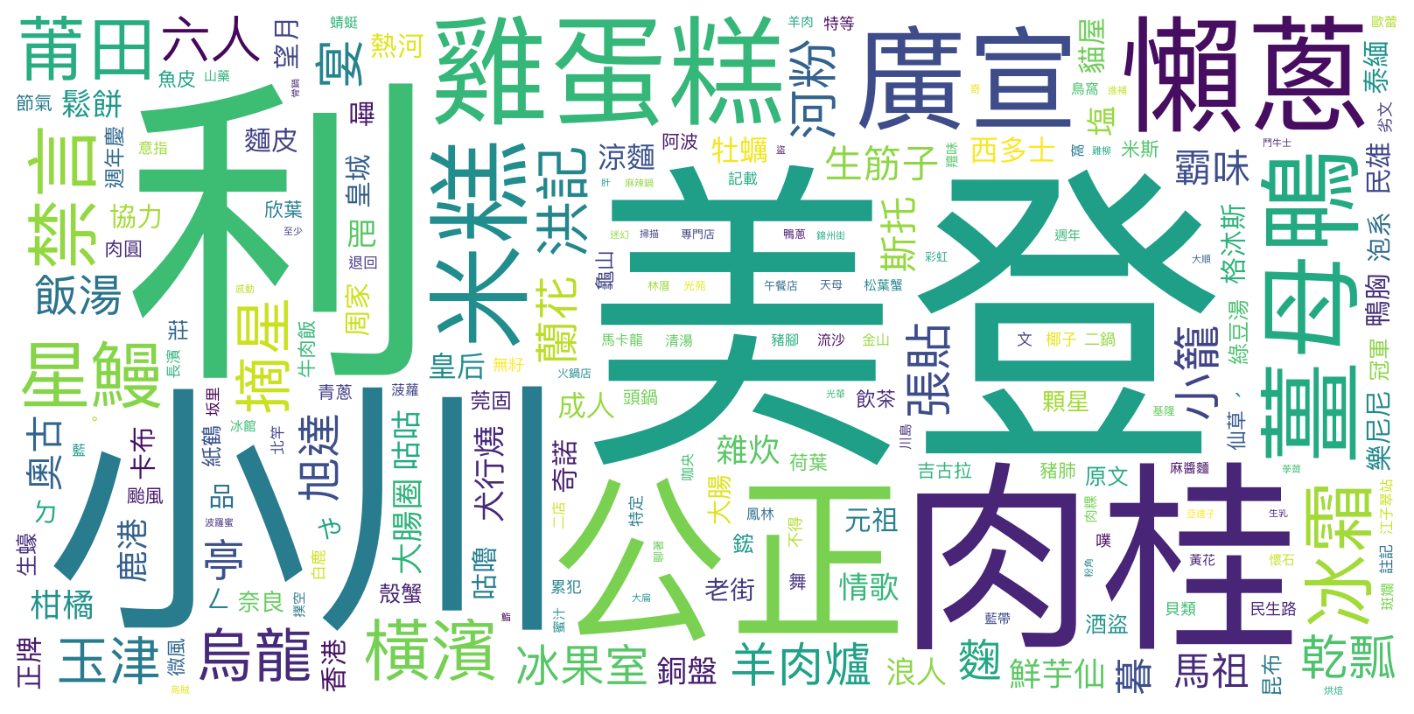

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
